In [1]:
import pandas as pd
from datetime import date
from datetime import timedelta
from datetime import *
import numpy as np
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.simplefilter('ignore')
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [6]:
raw_df = pd.read_csv("Electric_cost.csv")
raw_df


,DATE,Value
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151
...,...,...
392,9/1/2017,98.6154
393,10/1/2017,93.6137
394,11/1/2017,97.3359
395,12/1/2017,114.7212


In [7]:
if ((raw_df.duplicated()).sum() > 0):
    print("There are:",(raw_df.duplicated()).sum(), "duplicates.")
    raw_df.drop_duplicates(inplace=True)
    

raw_df

,DATE,Value
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151
...,...,...
392,9/1/2017,98.6154
393,10/1/2017,93.6137
394,11/1/2017,97.3359
395,12/1/2017,114.7212


In [14]:
raw_df.rename(columns = {list(raw_df)[0]:'Date'}, inplace=True)
raw_df.rename(columns = {list(raw_df)[len(list(raw_df))-1]:'Target'}, inplace=True)

raw_df

,Date,Target
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151
...,...,...
392,9/1/2017,98.6154
393,10/1/2017,93.6137
394,11/1/2017,97.3359
395,12/1/2017,114.7212


In [17]:
def convert_to_datetime(df):
    try:
        df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
    except:
        pass

    try:
        df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d')
    except:
        pass

    try:
        df['Date'] = pd.to_datetime(df['Date'], format='%Y/%d/%m')
    except:
        pass

    try:
        df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
    except:
        pass

    try:
        df['Date'] = pd.to_datetime(df['Date'], format='%d/%Y/%m')
    except:
        pass

    try:
        df['Date'] = pd.to_datetime(df['Date'], format='%m/%Y/%d')
    except:
        pass
 
convert_to_datetime(raw_df)

In [18]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    397 non-null    datetime64[ns]
 1   Target  397 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.3 KB


In [19]:
raw_df.sort_values(by=['Date'], inplace = True)

raw_df

,Date,Target
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151
...,...,...
392,2017-09-01,98.6154
393,2017-10-01,93.6137
394,2017-11-01,97.3359
395,2017-12-01,114.7212


In [20]:
# combining data set
numeric_df = raw_df._get_numeric_data()
df = pd.concat([raw_df.iloc[:,0],numeric_df], axis=1)
df

,Date,Target
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151
...,...,...
392,2017-09-01,98.6154
393,2017-10-01,93.6137
394,2017-11-01,97.3359
395,2017-12-01,114.7212


In [21]:
if ((df.duplicated()).sum() > 0):
    print("There are:",(df.duplicated()).sum(), "duplicates.")
    df.drop_duplicates(inplace=True)
    

df

,Date,Target
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151
...,...,...
392,2017-09-01,98.6154
393,2017-10-01,93.6137
394,2017-11-01,97.3359
395,2017-12-01,114.7212


In [22]:
# filling NaN values

df = df.fillna(method='ffill').fillna(method='bfill')

In [23]:
prop_df = df[["Date", "Target"]]
prop_df.columns = ["ds","y"]
prop_df

,ds,y
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151
...,...,...
392,2017-09-01,98.6154
393,2017-10-01,93.6137
394,2017-11-01,97.3359
395,2017-12-01,114.7212


In [41]:
def prophet_forecast(df, prediction_day, title):
    model = Prophet(interval_width = 0.95, daily_seasonality = True)
    model.fit(prop_df)
    future = model.make_future_dataframe(periods = prediction_day ,freq='D')
    forecast = model.predict(future)
    fig = model.plot(forecast, xlabel="Time", ylabel = "Target")
    ax = fig.gca()
    ax.set_title(title, size=26)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


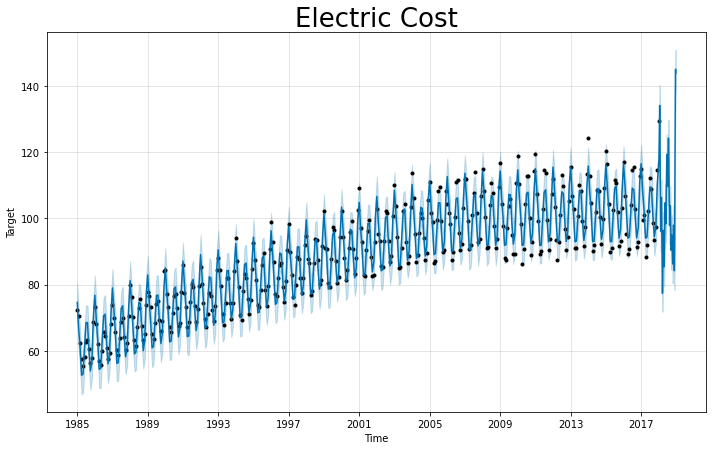

In [42]:
prophet_forecast(df, 350, "Electric Cost")

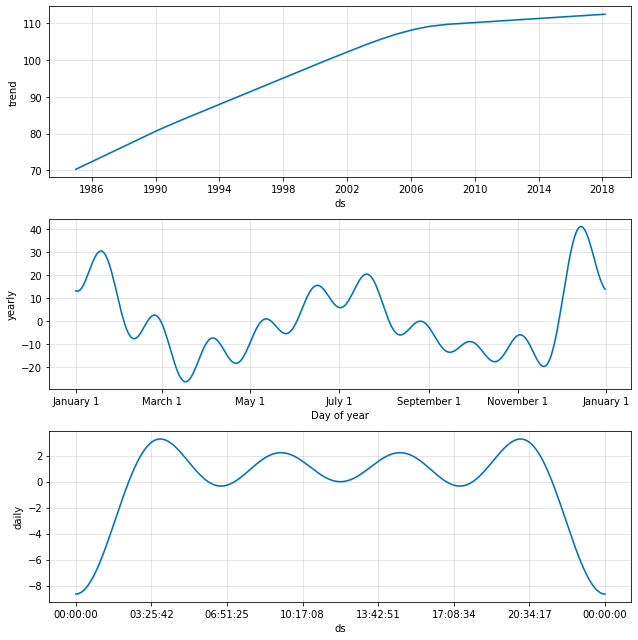

In [43]:
plt2 = model.plot_components(forecast)